# Imports

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd

# Hämta datan

In [242]:
iris = pd.read_csv("iris.csv")
mallcustomers = pd.read_csv("Mall_Customers.csv")

# Iris

In [243]:
# Vi kikar lite på iris datasetet
print("Datapoints:", len(iris))
iris.head()

Datapoints: 150


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [244]:
# Vi kikar efter saknande värden
missing_values = iris.isna().sum()
print("Missing values count: ", missing_values.sum())

Missing values count:  0


Inga värden saknas i alla fall.

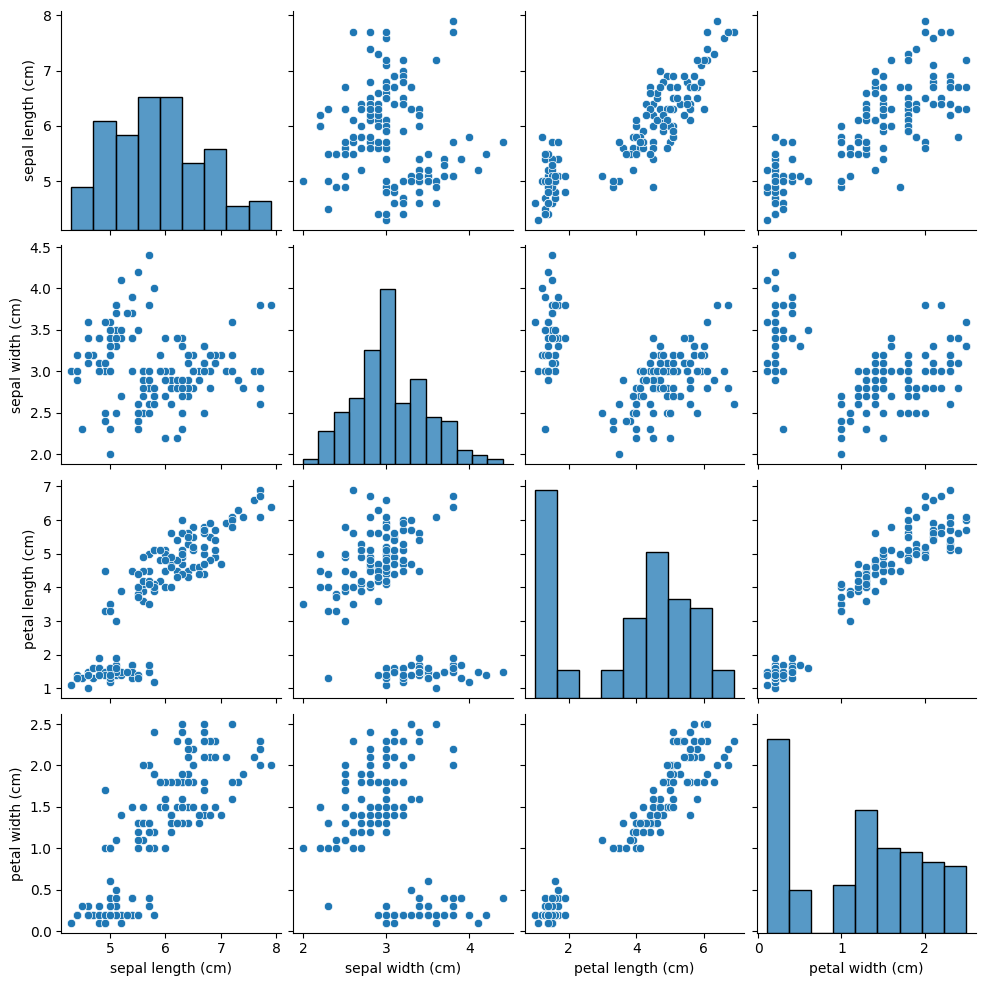

In [245]:
# Vi plottar med seaborn och leter efter outliers
sns.pairplot(iris)
plt.show()

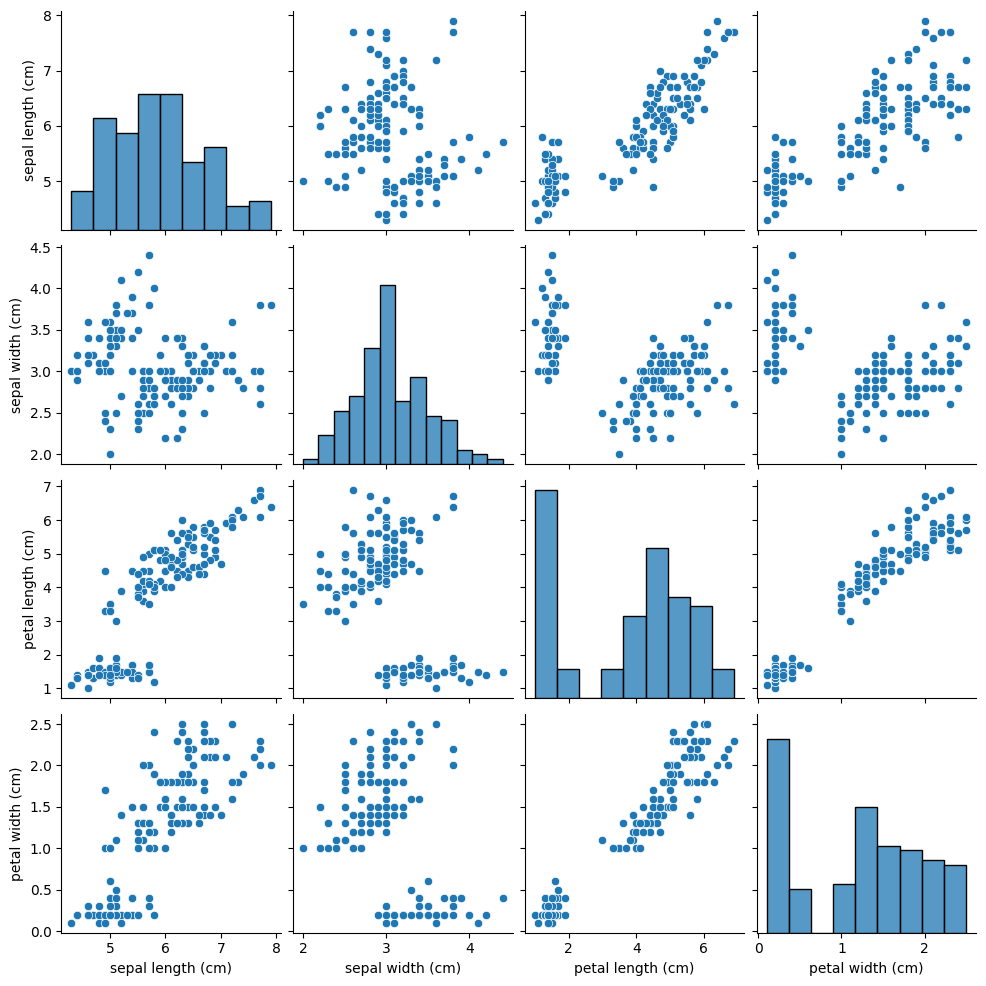

In [246]:
# Vi tar bort en punkt
iris = iris[ (iris['sepal width (cm)'] > 2.5) | (iris['petal width (cm)'] > 0.5) ]
sns.pairplot(iris)
plt.show()

In [247]:
# Finns det dubletter?
print( "Duplicates count: ", iris.duplicated().sum() )

Duplicates count:  1


In [248]:
# Vi tar bort den i så fall
iris.drop_duplicates(inplace=True)

# Mall Customers

In [249]:
# Vi kikar lite på mall customers datasetet
print("Datapoints:", len(mallcustomers))
mallcustomers.head()

Datapoints: 200


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [250]:
# Dubletter, värdern som saknas?
print( "Missing values count:", mallcustomers.isna().sum().sum() )
print( "Duplicates count:", mallcustomers.duplicated().sum() )


Missing values count: 0
Duplicates count: 0


Nepp, verkar inte så.

In [251]:
# Vi kan ta bort customer ID, den kolumnen har ingen betydelse för våran analys
mallcustomers = mallcustomers.iloc[:,1:]
mallcustomers.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Ett annat problem är att gender är strängar just nu, vi behöver konvertera det till tal för att det ska fungera som en vektor.

In [252]:
# Konvertera strängar för kön till tal
mallcustomers["Gender"] = mallcustomers["Gender"].map({"Male": 1, "Female": 2})
mallcustomers.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,2,20,16,6
3,2,23,16,77
4,2,31,17,40


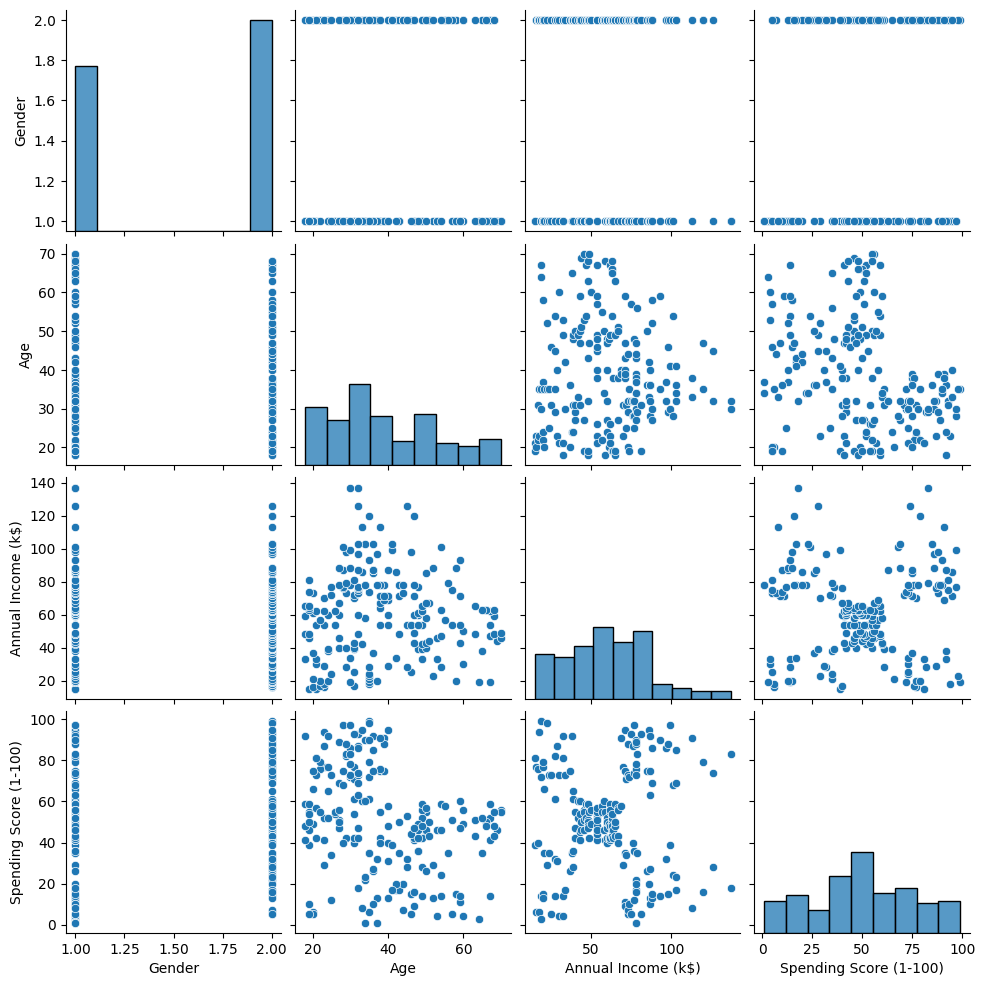

In [253]:
# Vi letar efter konstiga värden igenom att plotta
sns.pairplot(mallcustomers)
plt.show()

Det är två stycken personer som har en väldigt hög inkomst, dom kanske bråkar med statestiken, så jag tycker vi gör oss av med dom.

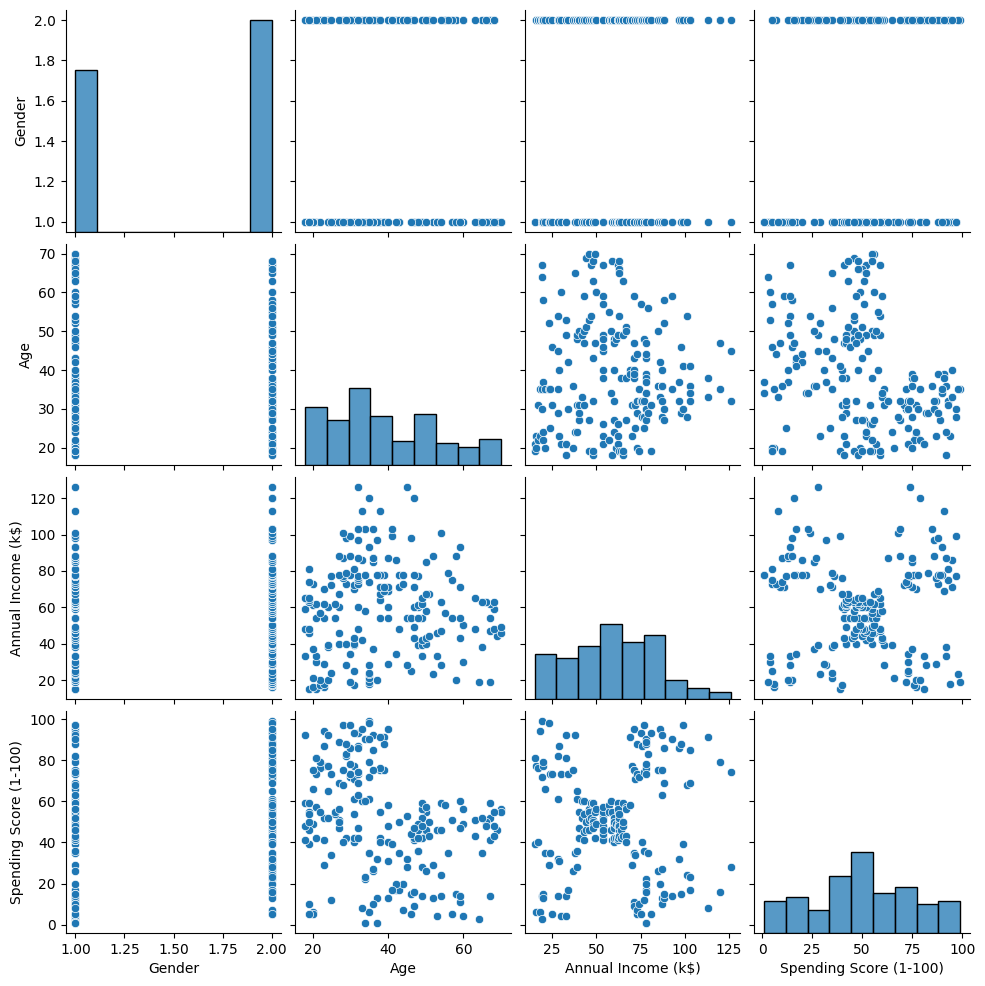

In [254]:
mallcustomers = mallcustomers[ mallcustomers["Annual Income (k$)"] < 130 ]
sns.pairplot(mallcustomers)
plt.show()

# Min egna K-Means

In [255]:
class MyKMeans:
    def __init__(self, k:int, random_state:int=42) -> None:
        """ My epic K-Means algorithm! """
        self._k = k
        self._random_state = random_state

    def _create_rand_point(self, data:pd.DataFrame):
        """ Skapa en slumpmässig punkt som skulle passa in i datasetet """

        n_dimensions = data.shape[1]

        # Vi bestämmer om punkten ska vara float eller int igenom att kolla på detta attribut
        attr_test = data.iloc[1, :1].values[0]

        if isinstance(attr_test, np.float64):
            # Float
            rand_point = np.array([np.float64(0) for _ in range(n_dimensions)]) # Gör en vektor med floats
            rand_func = rnd.uniform
        elif isinstance(attr_test, np.int64):
            # Integer
            rand_point = np.array([np.int64(0) for _ in range(n_dimensions)]) # Gör en vektor med ints
            rand_func = rnd.randint
        else:
            # Något annat skräp
            raise ValueError("Datan får endast innehålla 'np.float64' eller 'np.int64'!")

        for i in range(1, n_dimensions+1):
            attr_min = data.iloc[:, :i].values.min() # Min värdet för attributet
            attr_max = data.iloc[:, :i].values.max() # Max värdet för attributet
            rand_point[i-1] = rand_func(attr_min, attr_max) # Vi vill ha ett slumpmässigt värde som skulle passa det här attributet

        return rand_point

    def cluster(self, data:pd.DataFrame, iterations:int=300) -> list:
        """ Skapa kluster """

        # Hantera random state
        if not self._random_state is None:
            rnd.seed(self._random_state)

        n_centeroids = self._k

        # Skapa centeroiderna
        centeroids = [self._create_rand_point(data) for _ in range(n_centeroids)]

        
        for _ in range(iterations):

            clusters = []
            datapoints_clustered = [[] for _ in range(n_centeroids)]

            # Hitta närmaste centeroiderna för varje punkt
            for i, point in enumerate(data.values):
                mindist = None
                nearest_centeroid_idx = None
                cluster_nr = None

                for j, centeroid in enumerate(centeroids):
                    dist = np.linalg.norm(point - centeroid)
                    if (mindist is None or dist < mindist):
                        mindist = dist
                        nearest_centeroid_idx = j
                        cluster_nr = j+1

                # Tokigheter
                if cluster_nr is None:
                    raise Exception("Nej nu blev det fan tokigt...")
                
                clusters.append(cluster_nr)
                datapoints_clustered[nearest_centeroid_idx].append(point)

            # Flytta centreroiderna till average positionen för respektive kluster
            for i, points in enumerate(datapoints_clustered):
                if len(points) == 0:  # Inga punkter i det här klustret, ge centeroiden en ny slumpmässig position
                    centeroids[i] = self._create_rand_point(data)
                else:
                    centeroids[i] = np.mean(points, axis=0)

        return clusters
            

# Min K-Means med iris

K = 2


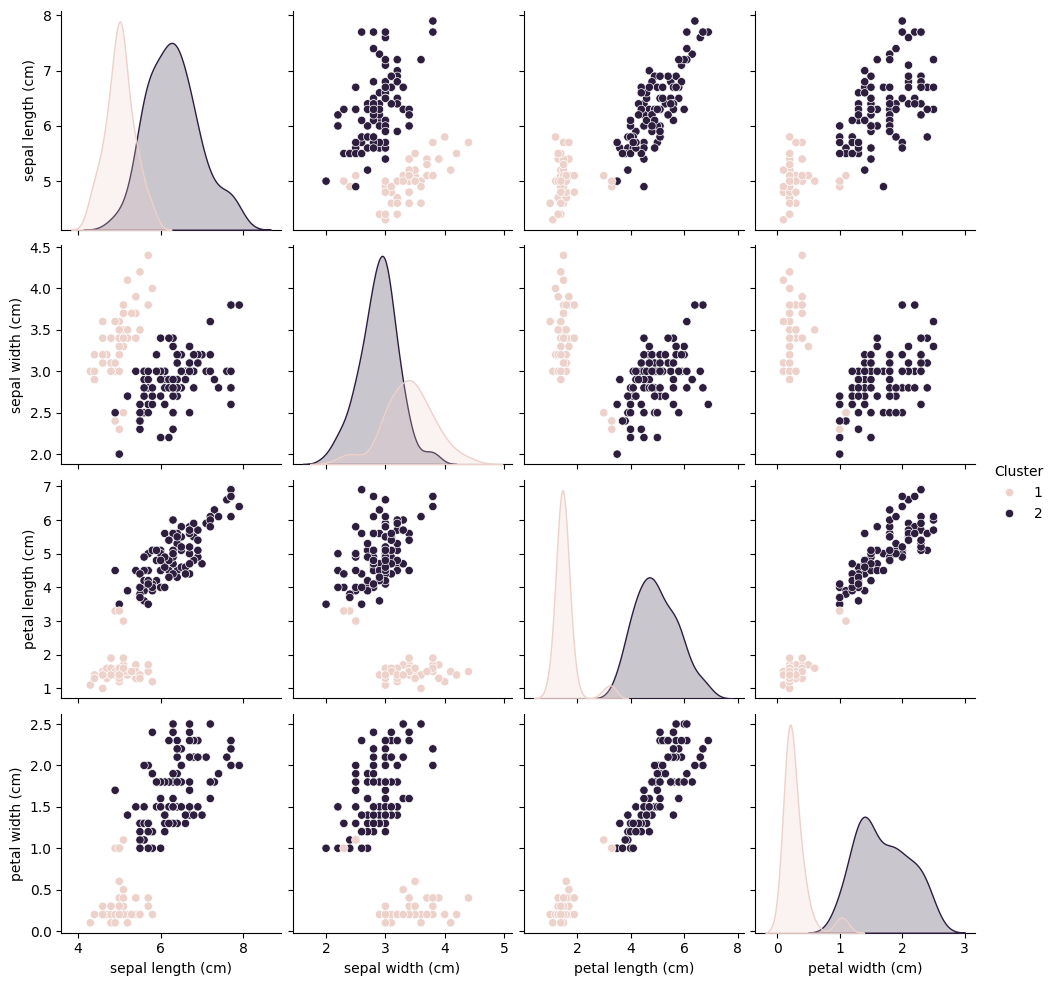

K = 3


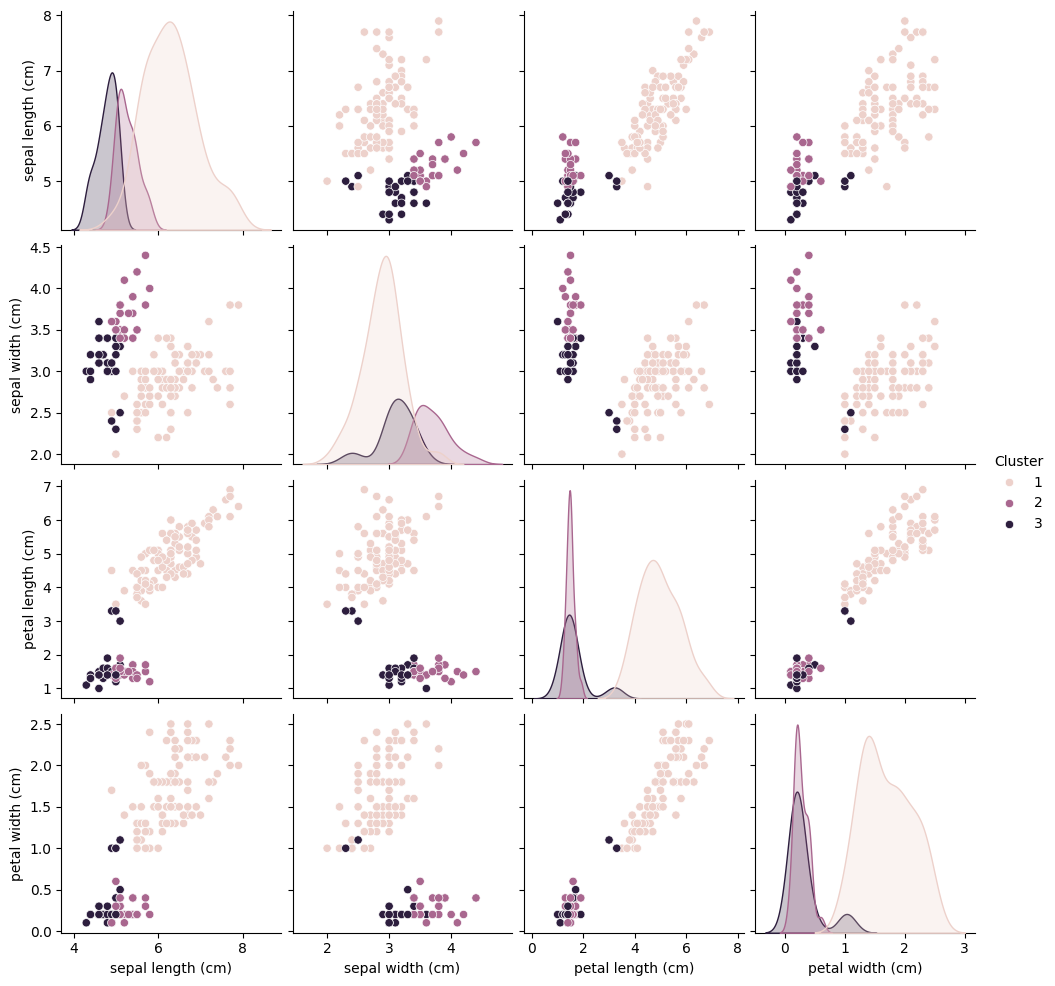

K = 4


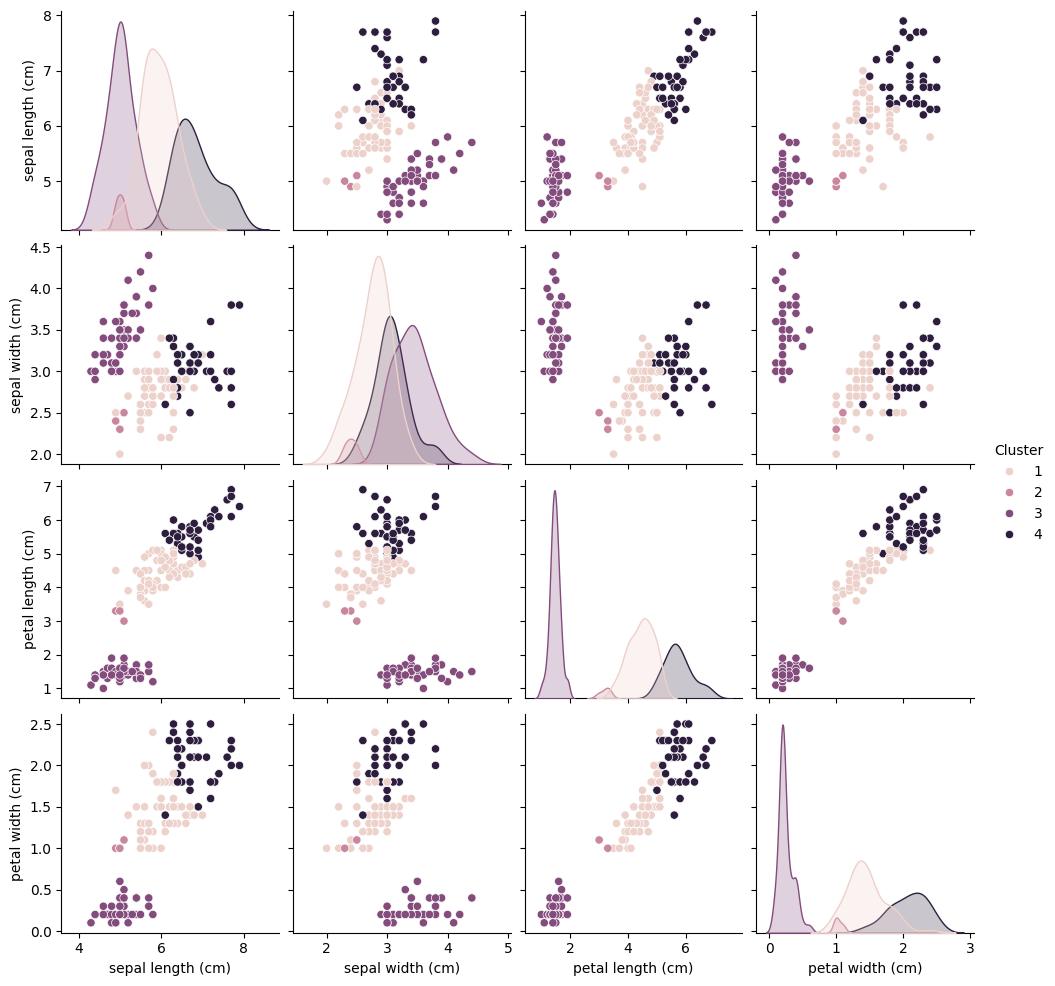

In [256]:
for k in range(2, 5):
    print(f"K = {k}")
    kmeans = MyKMeans(k)
    clusters = kmeans.cluster(iris)
    iris["Cluster"] = clusters
    sns.pairplot(iris, hue="Cluster")
    plt.show()

# Min K-Means med mall customers

K = 2


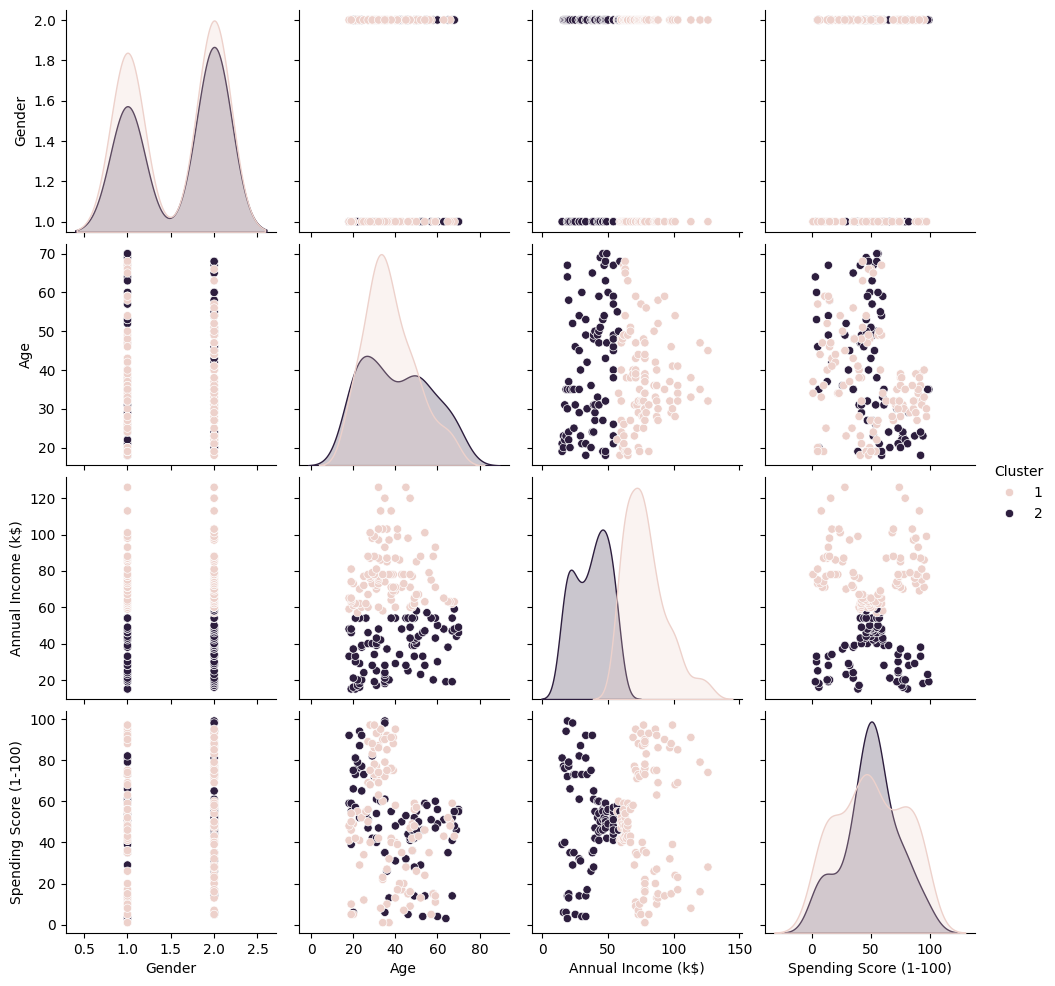

K = 3


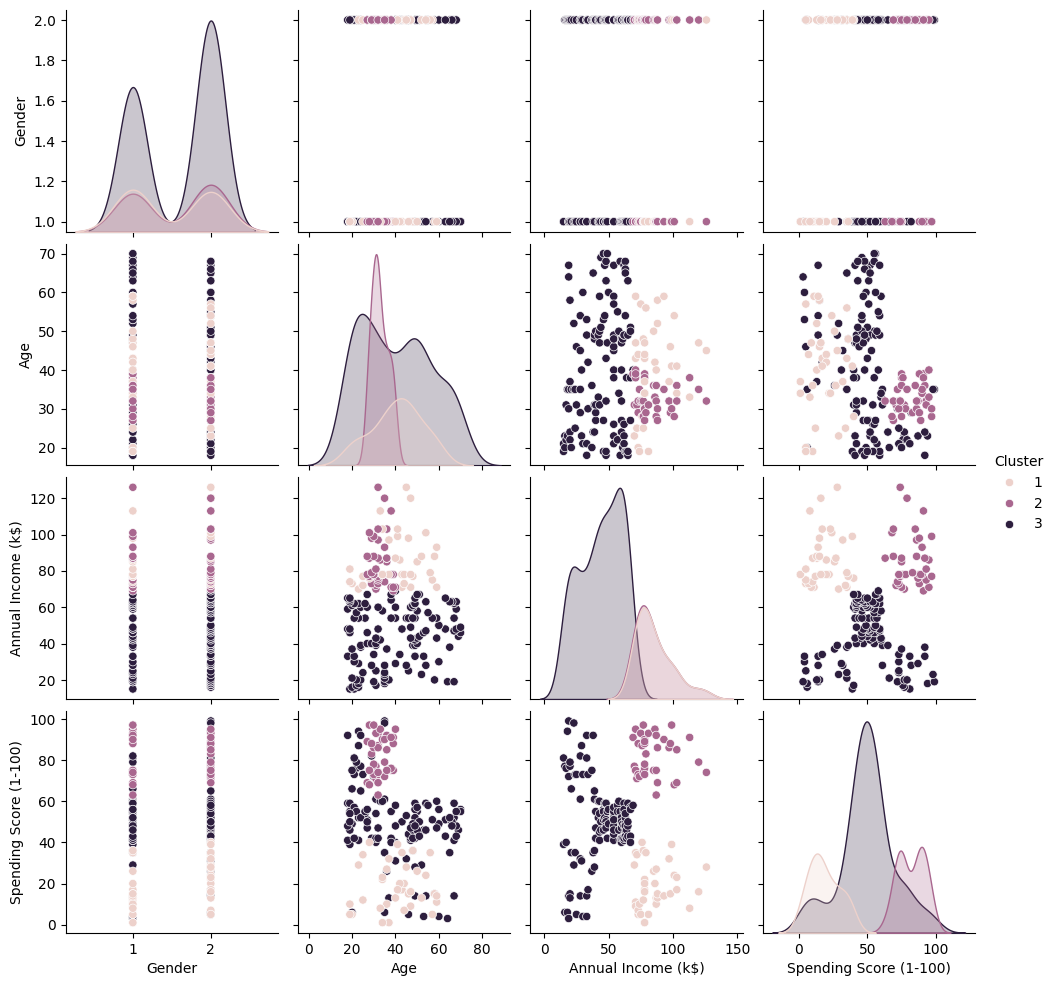

K = 4


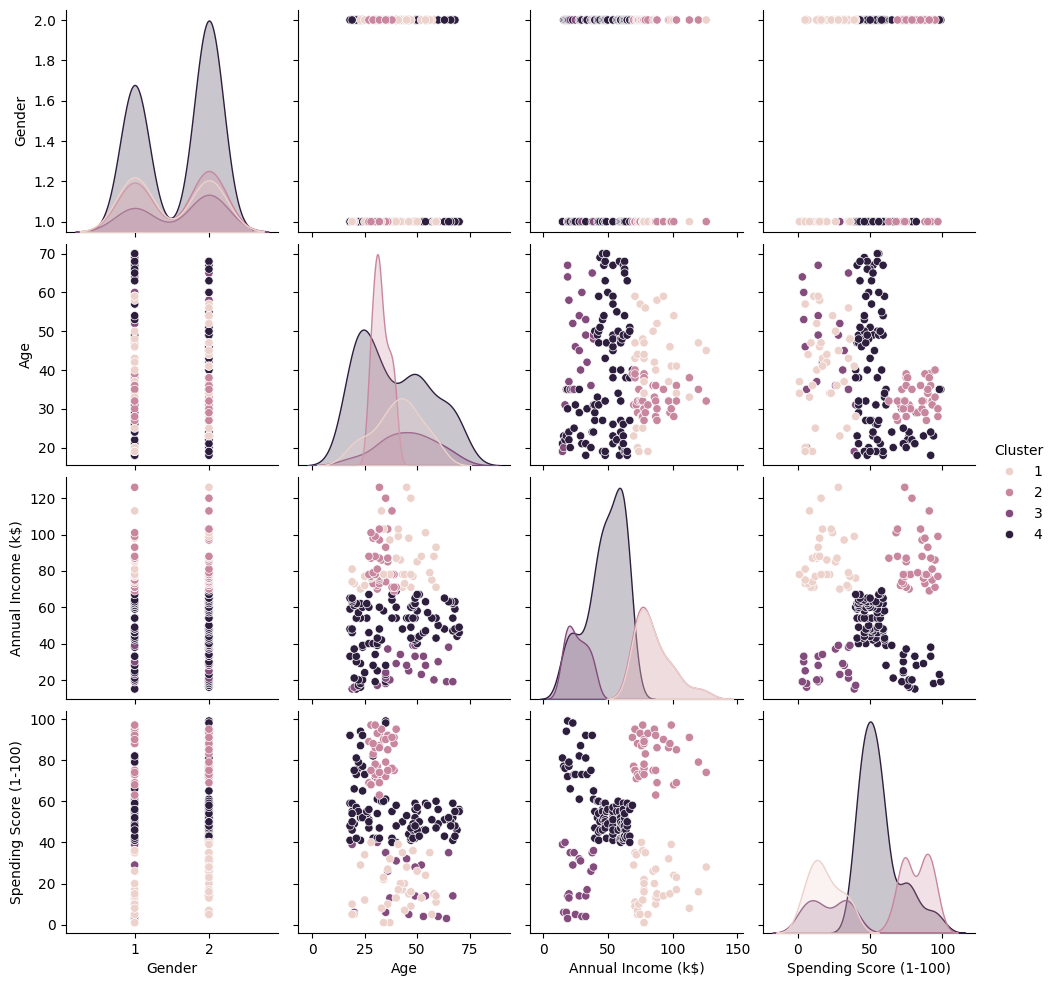

K = 5


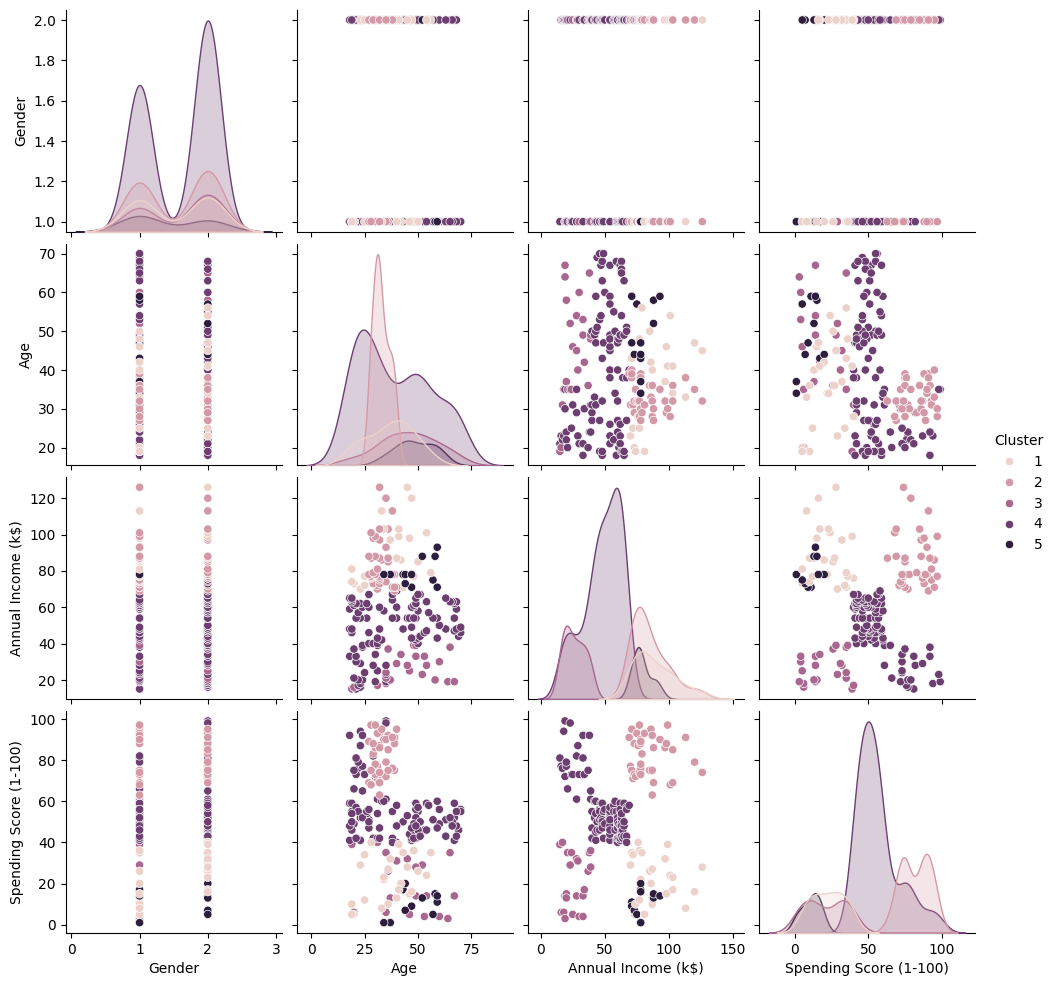

In [257]:
for k in range(2, 6):
    print(f"K = {k}")
    kmeans = MyKMeans(k)
    clusters = kmeans.cluster(mallcustomers)
    mallcustomers["Cluster"] = clusters
    sns.pairplot(mallcustomers, hue="Cluster")
    plt.show()

Jag tycker forfarande den borde ha kunnat klassifisera bättre med 5 kluster här. Annual Income/ Spending score diagramen får det att se ut som att det är 5. Möjligen att man skulle kunna få bättre resultat med ett annat random state? Och ett annat antal iterationer?